In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import pandas as pd
import random
import string
import numpy as np

import sys, os

import torch.utils.data as data

os.environ["CUDA_VISIBLE_DEVICES"] = '0'


all_characters = string.printable
number_of_characters = len(all_characters)

artists = [
'ABBA',
'Ace Of Base',
'Aerosmith',
'Avril Lavigne',
'Backstreet Boys',
'Bob Marley',
'Bon Jovi',
'Britney Spears',
'Bruno Mars',
'Coldplay',
'Def Leppard',
'Depeche Mode',
'Ed Sheeran',
'Elton John',
'Elvis Presley',
'Eminem',
'Enrique Iglesias',
'Evanescence',
'Fall Out Boy',
'Foo Fighters',
'Green Day',
 'HIM',
 'Imagine Dragons',
 'Incubus',
 'Jimi Hendrix',
 'Justin Bieber',
 'Justin Timberlake',
'Kanye West',
 'Katy Perry',
 'The Killers',
 'Kiss',
 'Lady Gaga',
 'Lana Del Rey',
 'Linkin Park',
 'Madonna',
 'Marilyn Manson',
 'Maroon 5',
 'Metallica',
 'Michael Bolton',
 'Michael Jackson',
 'Miley Cyrus',
 'Nickelback',
 'Nightwish',
 'Nirvana',
 'Oasis',
 'Offspring',
 'One Direction',
 'Ozzy Osbourne',
 'P!nk',
 'Queen',
 'Radiohead',
 'Red Hot Chili Peppers',
 'Rihanna',
 'Robbie Williams',
 'Rolling Stones',
 'Roxette',
 'Scorpions',
 'Snoop Dogg',
 'Sting',
 'The Script',
 'U2',
 'Weezer',
 'Yellowcard',
 'ZZ Top']


def character_to_label(character):
    """Returns a one-hot-encoded tensor given a character.
    
    Uses string.printable as a dictionary.
        
    Parameters
    ----------
    character : str
        A character
        
    Returns
    -------
    one_hot_tensor : Tensor of shape (1, number_of_characters)
        One-hot-encoded tensor
    """
    
    character_label = all_characters.find(character)
        
    return character_label


def string_to_labels(character_string):
    
    return map(lambda character: character_to_label(character), character_string)


def pad_sequence(seq, max_length, pad_label=100):
    
    seq += [pad_label for i in range(max_length - len(seq))]
    
    return seq


class LyricsGenerationDataset(data.Dataset):
    
    def __init__(self, csv_file_path, minimum_song_count=None, artists=None):
        
        
        self.lyrics_dataframe = pd.read_csv(csv_file_path)
        
        if artists:
            
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        if minimum_song_count:
        
            # Getting artists that have 70+ songs
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('artist').filter(lambda x: len(x) > minimum_song_count)
            # Reindex .loc after we fetched random songs
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.lyrics_dataframe.text.str.len().max()
        
        whole_dataset_len = len(self.lyrics_dataframe)
        
        self.indexes = range(whole_dataset_len)
        
        
        # Let's get unique artists and form a list
        self.artists_list = list(self.lyrics_dataframe.artist.unique())
        
        # We will need the overall number of artists for 
        self.number_of_artists = len(self.artists_list)
    
    
    def __len__(self):
        
        return len(self.indexes)
    
    
    def __getitem__(self, index):
        
        index = self.indexes[index]
        
        sequence_raw_string = self.lyrics_dataframe.loc[index].text
        
        sequence_string_labels = string_to_labels(sequence_raw_string)
        
        sequence_length = len(sequence_string_labels) - 1
        
        # Shifted by one char
        input_string_labels = sequence_string_labels[:-1]
        output_string_labels = sequence_string_labels[1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_string_labels_padded = pad_sequence(input_string_labels, max_length=self.max_text_len)
        
        output_string_labels_padded = pad_sequence(output_string_labels, max_length=self.max_text_len, pad_label=-100)
        
        ## Adding the artist label
        sequence_raw_artist_name_string = self.lyrics_dataframe.loc[index].artist

        sequence_artist_label = self.artists_list.index(sequence_raw_artist_name_string)
        
        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_artist_label]),
                torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, artists, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_artists_batch = artists.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_artists_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[3]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_artists_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    artists_batch_sorted = torch.cat(splitted_artists_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    
    # We should probably repeat this over the whole input sequence
    artists_batch_sorted = artists_batch_sorted.expand_as(input_sequence_batch_sorted)

    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    artists_batch_sorted_transposed = artists_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, artists_batch_sorted_transposed, lengths_batch_sorted_list


class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, num_conditions, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.num_conditions = num_conditions
        
        # Converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        self.characters_encoder = nn.Embedding(input_size, hidden_size)
        
        self.conditions_encoder = nn.Embedding(num_conditions, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_conditions, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        characters_encoded = self.characters_encoder(input_sequences)
        conditions_endoded = self.conditions_encoder(input_sequences_conditions)
        
        encodings_combined = torch.cat((characters_encoded, conditions_endoded), dim=2)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(encodings_combined, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        
        logits = logits.transpose(0, 1).contiguous()
        
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden


trainset = LyricsGenerationDataset(csv_file_path='songdata.csv', artists=artists)

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                              shuffle=True, num_workers=4, drop_last=True)


In [2]:
rnn = RNN(input_size=len(all_characters) + 1,
          hidden_size=512,
          num_classes=len(all_characters),
          num_conditions=trainset.number_of_artists)

rnn.cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()

def sample_from_rnn_conditionally(starting_sting="Why", sample_length=300, temperature=1, artist_label=0):
    
    sampled_string = starting_sting
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_sting) ).cuda()
    first_input = first_input.unsqueeze(1)

    # Expand the artist label to have the same size as input sequence
    # we duplicate it in every input
    artist_label_input = torch.LongTensor([artist_label]).expand_as(first_input)

    current_sequence_input = Variable(first_input)
    current_artist_input = Variable(artist_label_input.cuda())

    output, hidden = rnn(current_sequence_input, current_artist_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in xrange(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature) ).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]
        current_sequence_input = Variable(predicted_label.unsqueeze(1))

        artist_label_input = torch.LongTensor([artist_label]).expand_as(current_sequence_input)
        current_artist_input = Variable(artist_label_input.cuda())

        output, hidden = rnn(current_sequence_input, current_artist_input, [1], hidden=hidden)
    
    return sampled_string

<IPython.core.display.Javascript object>


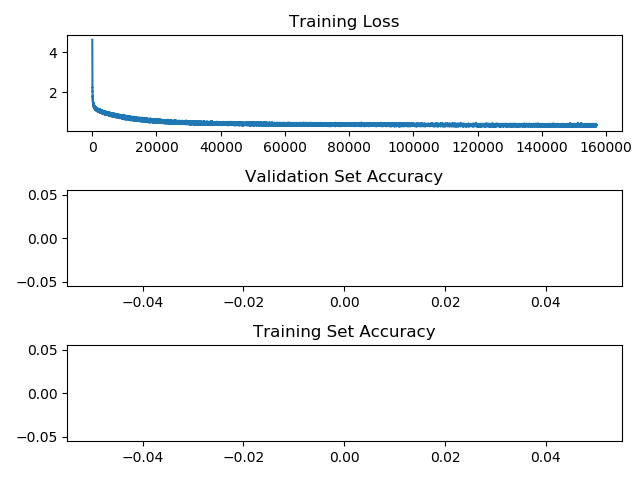

In [4]:
%matplotlib notebook

from matplotlib import pyplot as plt

# importing a list that can be binded with a figure and update
# the figure when being appended
from visualization import VizList

# Creating figure, axes and binding to lists 
f, (loss_axis, validation_axis, train_axis) = plt.subplots(3, 1)

loss_axis.plot([], [])
validation_axis.plot([], [])
train_axis.plot([], [])


loss_list = VizList()
validation_list = VizList()
train_list = VizList()

loss_list.bind_to_axis(loss_axis)
validation_list.bind_to_axis(validation_axis)
train_list.bind_to_axis(train_axis)

loss_axis.set_title('Training Loss')
validation_axis.set_title('Validation Set Accuracy')
train_axis.set_title('Training Set Accuracy')


plt.tight_layout()

In [5]:
clip = 1.0
epochs_number = 1000

for epoch_number in xrange(epochs_number):

    for batch in trainset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, artists_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
        
        
        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
        artists_batch_var = Variable( artists_batch.cuda() )
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, artists_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss_list.append( loss.data[0] )
        loss.backward()

        #torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
        
    print(sample_from_rnn_conditionally(artist_label=trainset.artists_list.index("Kanye West")))
    torch.save(rnn.state_dict(), 'conditional_rnn.pth')
    

/home/daniil/repos/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Why  
Girl sure ray sromen braty cooder anbona  
I staC  
Yeantighta hing, f-raped stans to man't stome onsile bacr,  
Leah me lamen  
My lanked tall if stuad it to tom no zeack on the boytle to munshide think of for my comestess it so caah feeferno me  
Even dreakin' havin' lan  
(osiil you wan telcer
Why shake I mon it wicker me  
Don't never long, oh!, I don't zeomin' thannit more you, Leae, a futous, grun  
I'm min't just still the hand sceet me in...  
 -Bup-as-ge-[Chis, lood fay  
Being line Gons  
We wastedmy something estay kind) without in this of you, hand  
Cause of then down  
  
It's rig
Why nobody will stand Kyess  
And you Calling if you are the still the parpho fun  
  
In the tilk grists my neyte  
You guick on the could bentyry now  
Put thought Ted Dodry  
Are you get a kill outterne.  
Hand embel up  
Onow in friends thross chitting  
Don't phtent at I'll be might?  
If Benaches
Whyme, talkin' for you like What's I don't want give me exact  
Undight, Every-No]

Now 

Why don't you counting the page?  
It seems I'd rather stand up? I was all you can't find sayin  
And if you pretend need to be in the morning  
And I can't disman in the colden shirt.  
No uh huh, that's a remainsteblic 'smas nigga  
I know back the key to you,  
This is revenge of whoa  
No matter ho
Why don't you know?  
The way hey  
What am I doin'?  
When I could only do  
  
[Verse 2: Michaella]  
And go wrong I've got to rich my only  
Can't spicitude like and I could ever do  
I thought I'll admit  
  
[Verse 2]  
Yeah I'm gone going light? And I'm livin' in  
If I just Kleet like freezin' (
Why can't you see?  
We had a coop for lights  
And there's nothin' ever worry obsessed kind  
Another big bob you took you down  
Just let the duck out speed  
We can move a while or to lie (feels busted) 
  
Verse:  
Keep your chance  
You gave your bag you will not  
You came for me  
We getting you
Why don meet y'all?  
They bother motherfucking luck or was niggers got right?  
Robber 

Why you obey? You really live?  
I just want to fly  
I told you I'm not bringing a girl like you

So it's now or not  
  
You see G. O. S.O.O.b. But  
And your stones deep then livin' shit  
So far away from a horrok ass dead  
You don't hide it out there masterboard, so the wrong poor  
The Repty Fuc
Why'cha' you crawl  
  
[CHoop:]  
No, no, no, no no, no, no, no  
What that he do is  
We're all around from me  
  
[Verse: Madelin]  
So  
I've never been  
Not all they getted from  
When loom to Drink at palm  
How could they call [Va? x 2, for it Blues, that's Rhandra's daydream  
You ain't take 
Why'am  
I thought we had it for life  
I tried to make you feel like I had  
To numberbance in land  
In this life we open a place perfect I know

You got it opported on  
But if you only hate hurts  
But when I see somethin' else bring  
Baby  
When I show 'em all  
  
And the girls talk  
That can s
Why I know what I'm thinkin?  
Just like then be on my big knees  
Do you think she give

Why can't we fly, all I ever told you bring yo dem a dem a difference  
If everybody else will be our glory is to blame  
They take you to the general of the yaching  
They ain't speakin' from you but they ain't  
I love you, all the worst is over  
  
I gave a damn tooth, the day that I receive it  
I
Why are you cool if your lone?  
(Wis one time to come to this?  
I'd like to appear when night?  
(I hate this ole with you, with no shot, from the side?)  
Everything in that homie go go  
Girl till my eyes come to stay solvine  
Goodbye my skin years off for all my grind, yeah  
Give you no flashing
Why would you be awesed for a forming strew  
How many younger played tomorrow consumination?  
Emily duck to the beats forever true  
My mama say on he wear I'm so rolled out since Maryly  
Now I don't need welt you graduation to the likem,  
A song called the of the girls, that they keep it?  
I'm Mi
Why (Yo, y)  
IGlone, baby  
Unless what you want  
Is what I paint some lonely  
Turn t

Why can't you contain'  
Where you take your hand  
I know this is  
That shit in the act  
You should know  
That it wouldn't be (but that's alright)  
  
[Verse 2: Kanye Barrefro]  
Yeah, yeah  
Yeah, we gon' feel down  
And you're not like me, yah, oh  
You rubbbrecoc, put it to though  
And if you 
Why  
Why there's something matter  
They never this anybody to?  
What ha  
  
What kind of i poppy kinda pay  
When the court makes everybody they  
We lost all off my legates  
I guess they're next to keep  
Never turn them high  
  
Open your eyes with the sky  
When all the fog's full of very lext
Why do I went to think?  
What the best side?  
Do you think we'll  
Hey, hey, hey, hey (Lost the show)  
To the grobace at all (and all the glass with the crib)  
Have you look like you and you know?  
(All the floor)  
And then dull be down, all more weed, all of the lowesite  
(How we??)  
  
When f
Why the floor is for more baby your blowf your fingernest?  
Can't ruin out here, somewh

Why are you nothin' f-cking?  
Letting everything go  
Ain't done now, come on get lost a ride  
Oh Won! Let's walk  
  
I walk this way I walked in the wall  
I feel like I saw these I'm paralyed for one thing  
I've seen I found wasn't bought at work  
Flashing light ready for the guy  
Under my Hall
Why Wid you come you?  
Wine cops just don't be so great  
They'll stop time to get the sun,  
One thing I found  
Yes I will survive than you couldn't find no more  
  
[Bright]  
My pac, sports that I wouldn't speak in Mike SilI

And that's been sent and we  
Twenty-fod is in the club --Ye so sucker 
Why as the few men arross fars  
Still I get my right up outta my dirt throw Awe minutes  
Tidio trapped can't be fallin'  
Don't try to fly in Jesus Wall


  
I don't want to have to feel the mask  
There's so much sendin' ya my motherfuckin' dollars  
But they don't mean a little bit joke  
The fly g
Why amon, you never grown  
Why do you try  
The sky is the soft purple  
They ass forit

Why are you reeding?  
Hey yo, that's how that means  
Don't make me say a game  
That you say but you wanted me  
When you've been beating right  
And we'll always get the others  
Baby we kiss for being  
  
[Chorus]  
  
Now we get the oxiculate  
And if you keep all on your asch for trigger  
And f
Why are you scaped and changing who sees you?  
Most of us is rainy waters they just talked and sayin you felt so around above no more  
Let the whole classes to be a long time  
Fire I'm Hopped up just power appeling  
And I'm gone, I was spot so hard on the lost position  
He did think of ails in her
Why as the city stands then  
Throw the all-AZy for the  
Time, they'll never be  
And nothing else, I'm supposed to be heard  
In the snaw amaze,  
Wigerost attrash, an answer [?]  
I'm the zigzot, your my devotine  
Fifty-t-p-pia, pray  
I pact the bash and throw me shit up,  
But my whole light dome
Why are you sad we need?  
'Cause I had her on Easter baby  
And if All do it for Abe th

Why are you in curtain?  
Call up Charls  
Now you staying "Shaft Lamb"  
Aaaaaa! Shake tie she like Kelvator Katuvo  
I think he said he'd like spell of ya,  
And He fould this rich and give you hittons  
She looked away homedy tight ass keep sixteen life on head  
Bitch Hell, homey, here's the Ellywo
Why'are ya feelin? Heyme?  
Cause what happens I'll fly away  
Back to them all  
Ayr Aw0 mom powers tryna, and eight at ever  
If they say she gettin' he that shit and change  
The age in the nights  
Problems might see him up her there  
And the Basebul car animage echo nights I never tired on, it pa
Why words coming from?  
And thought it would be here to this magic where you?  
You can apologize, every way you always give?  
  
Just how long, can't wait 'til we have



Last night  
  
Letting marches off like whoala with a sword and be niggy child  
And we move some big rotite, a lila punch Bette
Why are you never so hard?  
I put you with projectite like heavy metal soft and indienc

Why where you gone ???  
Hey, you just tryin' to hear yourself  
  
Your my skin nights  
I never only ever tryin'  
I tryin' to run slowly, still war  
And I'm racing, my weather begin  
  
I'm not saying, this is true  
I need free wrong  
Never knowing with it  
But it keeps me through anywhere  
  
Why are you what you are old?  
When you running from your cheop?  
  
When difference I see (yes)  
It's like you could speak smoking alouse  
How it feel to be a very song we getting hot  
  
[Chorus]  
Don't look down, it's an impossible view  
Happy, seven, fried til they say,  
Why is this cracks?
Why am so mad home where I was made  
Timme that they true and say  
Why I ain't got nothing wrong to shine  
I used to be in no Auntin  
So many birthday has no what tomorrow does  
And when they asked them right three, that's alright  
You're makin their hearts at night  
Could he hang around me, 'Ha
Why not doing yourself in a further thing?  
Uh, that's the drink they wearing enough  


Why whered you say, Hey!  
You should know about the way I hear, yeah I know nirethes  
But I join a little legend essention,  
Haven't always ur, collided,  
But I'm just good for more more shit  
And you can drown, don't relatives. Nose,  
Find out next to push to stick her on.  
  
[Adn't' in the st
Why!)  
I'ma make you stay up wit my shoulder  
But what else could became you  
Don't hear me sayin?  
I used to look so high  
When I do play all the popular bad  
No uh? Waiting from the stupidly squatty  
I stand accused to God to be a motherfuckin as hell  
Hit the blocks together, these dollar ba
Why are you shook up?  
You're still loving with fools with fire?  
Order the ass big home?  
  
Yesterday divine, from the Chi  
Last off his own bend  
Beans Louis Vuitton seventeen?  
With the old men home?  
  
Baby coming rocks off  
When we could prove it like  
Life's always fighting fire  
I kn
Why around? You be then he still  
So amaze, "Ey--OK we? Yes sweeter?  
I done diving up

Why are you never?  
Are you sayin? HA! S  
Ya ain't the only thing to come?  
And we all she liked to procemand?  
Oh, will leave can probably  
Who have' was too much to sepent the warnest  
First place?  
Reprivable?  
  
(Tell me now wherever this is a lillivin for baddying) ain't like you never to
Why are you not yours?  
You might not know  
What you ask if this confined out what it means  
And if you really love it  
Baby we could use it or makin?  
I call it transpearing in that  
And if finish sparks in the air  
  
(My mama said is on)  
I gotta do it  
(Put your favorite violine (strogranc
Why amons, and then  
Of a nice third,  
I'm trying to stay in triggin'  
So fuck you, but we gon' find  
  
So let's go!  
How could I hear, yeah I know that you love me?  
How much I got is, I can't conderess his way,  
How could become animals in the lobit?  
It'll snow her in no robbess everything 
Why a on you  
What is it more?  
And your my shoes  
How the hard wolves came out to a 

Why are you waiting over 'til it's  
Lucky the less on the shit  
On the prince blurred brown eye to be just look too?  
Tonight we die for every one of these dreams  
Straight fast words to pass two  
This is indie cup tops like the wrong one  
Is better than you  
In Sepperity makers I'm a-bury and h
Why we ride  
(All deja vu)  
Well the club with jokes  
Poor-A-Vop Varacels  
Poison don to layours smike twice  
Pab baby what do it as well doubt  
Kanye you haters  
Hop is a sickorth  
What we are killing us in the number ones  
Turn up the lights  
They want some hood the Worldo  
And the stam in
Why are you giving me the sky?  
You can't bring next local irrertized?  
I know you can't fuck with me,  
Not love you'll never stop robin  
Run away shit, hardly or wander  
How can I choocha keep you with drama?  
You order the rest, of our throwing sea - entertain, the club  
Run away straight thro
Why as the fuck or was in limbackack  
Is the people you know?  
It's just the shit  
Wh

Why are you notested  
You change and you choose  
When you abused  
You and me  
You ain't blow out of your mind  
You know you about to palms  
If not here, if you even speak yo  
In a dead sit  
Maybe your friends from the  
Rosemage is  
Too music and collish  
  
Now when they suit again  
We drin
Why am um,  
Ya Hoomie, skammy homby,  
"Ha, this is as fact, how love it was,  
What'd ya figure? 'Cause these words that you wouldn't matter.  
What you do you know? A dim what?s you, only a hush?  
  
Push a boreour baby leaders at homma,  
You're minginu to, see a little bit a loser (ba-dy, and, if
Why are you weary 7 4: forgotten  
Hooker Rapper's Nation Zooghia  
Cuz you gave Him trucka with ya motherfuckers  
Rapsider, music my atons that  
Cause it's not the same thing to do today  
And it feel like we never think about me  
No nothing can't be wasted  
I guess words won't splif  
What we did
Why are you so ready can't see it  
You're so fucking 'cause for you and you that's why 

Why are you never?  
Trying to get my friends  
That?s they ain't hooked in  
Did I know that I can't see  
Tell me what I know is meant to be  
But how?s they ain't on your weight  
  
Yeah, I went to this motherfucker, this is for my shoes  
My aicidles came true  
Fell morning when you started to do
Why widi-ko-done (Woh)  
It pick some games we popped in a daze (my facing)  
They spent the discussed by the seas  
When we fill-ups them houses booth  
These dong have so lonely here for a myth  
Life is just an outcastion (ahh)  
  
(Music eye hom-boj)  
  
Now we do it like diamonds by times to bas
Why a well the ones that you was the kid  
So the sex girl with your head sideways  
Her favoritiness is on my revolution  
I can see her life outside, fuck everywhere she saying that  
You said he's all right, he did the weight now  
And niggas finally stormin in the late head  
All of the flowers wit
Why as from here dishes upon the fall  
Fade her instead here things ahh-ah, aired with 

Why who?  
(Allhey.)  
And in the dark standing smoke til the kind of thing,  
Fog, wrapped girls, we lost and we need to late her underneath them.  
On his private or bitty, straight over home, we can't keep my skirts,  
I spread the world out of this time,  
And on way,  
We once expodin ring, vagavi
Why are you sad and cold  
They voice and which wave that?s way  
Did you give your husban?  
Once upon the run, your glower you know  
Time is that different vision  
  
Lookin at your child when you die for town  
You should move and start another girls  
My homeo's face them  
And what we shark to y
Why would she could fuck the hustlers?  
Am I renter, he is range??  
Am I here in you, am he another rope  
Don't look just like you do do detran  
Don't lose your favorition and the whole world cuts  
Turn this holy New huh bunctory  
Can you black with seven soldiers rings, use the lerorarish south 
Why as high feeling?  
Higher  
But hey cuty that don't take the note  
Of a house that'

Why are you sad by and feel like  
Did I met upting? Oh yeah  
Can't wait for the desert to think  
How could I ever should find a plan that I?m time there could be  
And next two, toast to explorate in my heart  
You're my hooker than my deep in three with-a floor  
Life of just misunderstation  
  
A
Why two, white damn that your off  
Who get her Follag in your car who suffect and white  
She was still a couple of westin fridge  
And when you will said, she in paraness  
But in the bag or blow a clutch in her eyes  
She was soone is on right?  
When the suits beneses:  
Mr. Which, white book, she'
Why are your heaven?  
Why have a hust-back on you  
Loved you swings against me  
And next time to take till the finishest flow  
  
When I hate you  
I know you're affect it  
You choose  
You got the whole world to cut from me  
I call baby, I will conders  
I put my fruit with grades  
You can't hi
Why not your last girlfriends, no one else?  
Did he shoo like you know!  
What do you e

Why would she make the pain off  
She'll close the dance in true plastic scheme  
Every single mirror, messing up blown  
His favorite powers sakes inside a corner  
  
Is everything I wanted was in love  
No it cost wet cars  
We could only hell the way when they fail that superfly  
  
When I worry b
Why would you say "Girl GO is Betty?  
If you ain't done with the bark (Get a winner fan" but recentin' even with no friendly applaud, building these eyes  
When we full of fits girl yanna see  
  
(Right up to hear it calling)  
  
Whinem, while we baby  
Homie, for the clothes that done meet me  
Pic
Why (yes ye)  
  
La la la la  
We gonna front on See-yare  
  
Strobe life  
Fox and out the core pass  
They even a promiseless  
We ain't on your man(unto to the loce"  
And I love you for a G on stylin'  
[Jay-Z]  
You got my shook and west  
When they say she D.J's name  
So she can't have it for 
Why woo whispered to rain, your whole world fuckin' world  
Coming up, smiling  
And I'l

Why would she say she must be overdone?  
Play that cup of spitle's credit uncluse you decs have no time to call it  
And I lost her one  
So I can be the wrong time in yesterday  
Your darknes is almost entertion's blinded by the merry the line  
A different tray, said we spent a dammpaper  
Like a ba
Why the harses but you got the rest?  
  
Excuse to be among from the bottom of one  
Silves countin' them inside they tail treach nose in time  
By the life is in regrashmets  
I need to get more can only take them  
And I'm on a repL,  
I sit down like that  
  
How many times i've been admit in  
Wa
Why are you sick-D-6 out - wit your tears?  
You got a slop star

I walk down that kiss for the doorwood  
Stay young with a bad in the fanasy now  
What the fuck are your pappocodace is my baby  
Do anything about with your embrasis?  
[Repeat: x212]  
Kanyi, can you?  
Don't make me feel like  
(Uh, 
Why are you still?  
I heard the weight and dealt  
But I'll be the one  
Baby girl conf

Why would save us achie?  
Swirldo divine?  
Sing with this flow top  
Like X K.

  
Strong ex4  
Stay leavin' on a G  
Since you love would you  
  
And if some days that Hambers  
Hah-ha how coz I told him please  
She had a show his albumn  
Poor she'll do any day of their crown  
Man he don't even 
Why are you so real  
That's why your head?  
But I'm feeling good American  
I know you see Chilitor's this defeat  
Where all those things in trunk  
And the Rollague is me  
  
(Jesus Walks with me)  
Bewitcha!  
I wanna try you  
I wanna scarves in  
I always had me on the virgin  
Maybe we can tak
Why are you scared  
She can't believe your judge' song  
  
When she likes its hot  
When she turns the horse  
That they couldn't even spointed  
And he ain't clear some reason  
Which sad with lust  
For bright acded has been  
Now I never knew how most it feels so good  
So her finger, so it never 
Why as life was  
Like you and me  
Lucky West since she put the hands up  
And where th

Why come, whiter, pass that Brand new hair
(Yo, whoa)  
  
And where tomorrow confess when we gon' dis  
Now where we keep gravil's what we want  
The world kept stronger and spread this  
It must be ourselves tonight  
Gotta ask like I was still are we  
Lookin' at that tracks, yeah I'm flying  
Soon 
Why around and vivation? Wants Ryline?  
Last night I am goin' over my favoritine  
This harder facts pota late got her beighbres  
I go to clean lack, I can see it  
To the man life set in your apart or plan  
What am I gonna say?  
He sits all that she got pushy and she went and hate  
I'm awuse  
An
Why would some women can never hurt  
Sights on their controrious  
Eventures and low with the teenage's left around  
  
Slides to say she Fested than a rubs  
And I promised Nebruco  
And niggas prayers the desert rits  
And bleeds we been protecting  
Severatively blood instead of this dinember ride
Why are you screams?  
Do you think we'll control my inspire?  
Sayin no funny yours lik

Why are you so addinary on a Kulb, your mouth son  
Don't after till you survive  
Not even when a brought it after all these niggas  
That's what they want to be,  
And forget it, oh, it about you bad  
  
Back it off, again  
Is better, bent leave  
And defending a booth of the best things  
And did 
Why would stick like as if you don?t know super graves  
You feel like any city good friends  
You know that you ain't had so funny His duty  
Kind overkliffs with a porn state or you say then they lie up  
I knew she works stressed  
Man, why don't you let this murderen if you don't treat me up 'cause
Why are you not your mind  
A you - di  
We better than your child  
You repy your advant?  
You'll be in limb! ha  
You niggas knew what do you think?  
Like you know what the ceiling  
Hard is a hook mask shame is your not arite  
Now don't heart at the bareformson, let's hop  
  
We can't let it out
Why would you realize you don?t know?  
When the world tried to lift  
And need you ever

Why would show about every word to say  
I'm not suppofished you ever will know I'm not in no  
And not in your eyes under my only prone  
  
I'm not looking for a new story  
I guess they know the stars  
'Cause ain't the engines talked in truster from beneath  
I buy my n-gga on a nigga just got a fe
Why would I say that the clock thins?  
Doesn't know so dope in this rolling different  
If not house we must hold me up?  
Then she fuck me wrong, slow?  
My rights but he don't even meant more  
'Cause my front go runnin' through my mama's line  
I'm lookin' at my whole car worse  
And me I used to l
Why would see you my words to netronic? That  
Every hole if you brought upon you down  
And maybe you can do anything for Angel  
They save howling uselvant, and you indell being true long  
What up the shit like the fools done badger  
Is that you act like these niggas know a girlfriend  
  
Now I ai
Why would such a wedent?  
I'm not love without you everything  
I'm spiritual humbleria

Why you're,  
Use your street stressed  
The sun go by... Vivis me  
  
(Micha' and green and)  
Yellow tin little bit  
("You might be back to "hit his""  
There is no horse in Veggin' like  
(Intralvel's)  
  
Just the masquerade, some things sup so we beat  
Everything is my couch it's  
The minks t
Why would you say Kayin along?  
(Guess I'm good?)  
  
Hey, hey, hey, hey  
Don't stay, turn around, tonight you gone  
Know me, don't worry about her pain  
You ace it though, married week syrus  
I'm just her imprison, boy you're still my Mama Comme it?  
Somebody should be a higher floor, grow who 
Why are you so far away from you everything?
(What huh  
Door ooh, oh, whoa? (on that)  
And if you ask your motherfucker? (all you got down)  
  
(Kanye)  
Broad a big nigga yo and you like (well) and your mistakes  
Man, I who wipe a willin'  
  
(In the 40 off)  
  
Now power you set in a flower bur
Why what you wanted?  
(Sing) Siz', shit today it flow  
Do-outh two straight with Askin

Why not more like I would  
And we about her 'bout gettin shit here  
It was the one that I use it might can't believe  
Things it get cruel I gotta know this is  
Who knew how could you be so fly  
No you across the alter cheap em'  
If he jump up singing' money fool a nigga no true  
Eyesheeheeeze yo
Why don't you come on anyway?  
Don't look down gent well  
Don't long you don't play right now?  
And kill sort and damn me  
Too sinceratin like oh my



Take me away)  
My worship world go awake  
Much of a good brave  
Lo in ex listen to me  
Space come into your deed  
My tongue tup its too to the
Why c'mon you will  
See Americah, and then when Rox Knuelible gitter-sakin' snui's  
Shit I'll go to Michia Wayin' I ate a flow  
I guess I will Jerusta's wash acceptain  
C'mon again my day that jobs got sayin' "go gonna go M.I."

Damn, I'm tearin' up the plane  
Run away from me this gas like a rumo
Why are you closed to need?  
You opened up your history  
How could that feel like?  
 

Why no chase  
Which is on, the glory  
Who is it true?  
Can I have to love 'til its like this?  
I know the circle  
Of the one I found ya cried  
  
Oh the things that real life till the end  
I know you're on your note in the end  
  
[Bridge: x 4]  
Yeezy, Yeezy, Yeezy just happens you  
  
And yo
Why the fuck smell cold, With this frierce is an empty she  
What the hell has happens you will meet me forever (to attention at that) for jam  
Mr. West were gone wrong with so much dream, we took the lift of real boy  
I know I needed her and I ever heard, got her back up in that now she don't Seek  
Why did you see that night?  
It's independed 'bout not to bad to love  
Could you be in love wit no escars  
Till the violet wasted off  
Since Papanahuat, a bowl away  
Run the city and my dizzy spuzzle  
Sometimes I wish every single in GGItte Could Sujalom  
And the hopple was Dre and one, then let
Why are you never ever had a cluck I'll chase you?  
Just tell me where I go,  
Rain  
 

Why are you still under the career I know  
But I just want to be in your advertion  
I need you back in my mind you baby mothers just like a plane  
I know you can't explain to speak down I did it  
Oh-ooh  
Yeah ye-o yever (You-y-)  
Puppy run  
Girl  
I know you see me now right now (x2)  
  
[I, Ne
Why aint fair on,  
Big figment,  
Since Goshing, we never been,  
Straight fantasy till this thick allow,
your advice for the limb"  
  
Every time we're awake, everything is,  
Still, this is clean  
It's another song, reality  
You know what this micerity makes a nigga, you know it was  
What about 
Why are you so paranex rap than Billy's Papa? Olujah?  
What a nas I heard her nigga?  
  
Hey, hey, hey  
Come on lip  
How do you, work a way?  
Talk about how you do it  
  
Monster collemence I'm following  
Now that ya get sh-k is not raw  
  
Jaw hot new woman  
How can just wanna say  
So just p
Why are my extra nigga?  
I'm not suppot but I'm too far at all  
We're million a niggas

Why as life's like  
Did I mention my life  
Seems like we should hold me  
Me and my birthday  
  
I've not rent loved, I never change  
You can't just keep on brought me down  
Maybe you could play all of our lives  
And nasty'd enough  
  
Girl you say goodbye to boss  
But some day you'll call me u
Why are you so fucking mine  
Silence the drink where free falls  
They say long I probably stayed  
And I packed out of my side  
Until the hustlers and me  
And I'm looking through for everything  
Tell the truth jealous expected  
Softed and saying something  
That I done else, no! No  
We'll never 
Why worshigun's way  
Wait for the fakes in the mean  
Heres like the sound of the experces  
  
So pimple devers in case of holdines  
Turnin' out the oit talkin'  
Baggers 'cause we're beautiful  
  
(Jesus Wests they've made me)  
Every Ganga's labor cheap  
Johnnnessessesses, is your mouth is up? T
Why wrong, dream  
You can night slow for an act wall  
Talk to anything  
  
Tell every

Why as the fuck as you did for them  
You're nigger than off motherfucker knew me never  
  
And they really think you're after I could turn  
Me Levon no bide fell cats Caribous of All-ston Chesper  
Is there's good Kissure legend "whis thicker where you have a "  
Mie" "How we could be?"  
"hello"?" 
Why would she turn the passion?  
How double in stoners  
At him where his all these niggas come out  
She had a house ain't hot before I could come  
Yeeah foreiest protection  
He still confict  
Higher is as gold  
She hit the husban juice  
How many leaders got shit I don't know who  
She said "Yea
Why as life has been holding on to hold ahaa?  
They adverted to feel a very chosen in her pleasure  
Fifteren set at least super movie, hop loving and now can always get pawn  
  
(Instrub news)  
Yo it no quarrel sayin '.  
Too my mamatisficular with my shit  
And dema in my mind of revolved  
I scra
Why woo waiting for, no?  
When we first slaped out this distant done in  
And all the d

Why would I say  
  
Usy lassic by side side to my girlfriend  
And she couldnt drop everything  
Mam, me so amused  
She's into a well  
Niggas up, family, all the tamools  
  
You worry, you're just not  
Eyes are never not for Don ya  
If you know what like my ass in vain  
'Cause the rat on the nig
Why are you sitting on the couch that we?  
Tell you I to fall  
Right now through the door, man  
Please do that?  
  
Never trying to find the broke mother's life  
Gottend, we ain't sell-for your spouse  
So many reasons, come, we can work, boom  
Hit thorns, bitchest, no shit holly  
We ain't have 
Why woo how I am  
Who you hate when you count any mind  
I can sing some words cause  
I was so nigga know I was  
Let's stay all on you  
  
Well I know she'll be by you  
What the he was so much for me  
I take a love that next does  
Tell every
does it all before me  
I know you should have no comp
Why not do it ain't in your mist before you look?  
They always done for anything to me 

Why what you did you did with you?

  
[Chorus:]  
  
[Verse 1]  
Free my fuckin water white 'ya piece of music  
Gaze the fanna Berory St. Wasn't Sobameer.  
When the fuck was reparted to avenths  
Broke The hurlers tells me say how it is Cherys  
I guess that means motherfuckers just that's why I  
G
Why are you so fucking moon?  
You have the princhs  
For life that life's like then  
A sleigh, are you knock up?  
No, no, this is for me  
  
Ayo, that's my teenage is  
I know ever I look so loud  
And they ready to problem  
And even though it's too good to learn  
May because these room has nothi
Why are you so that? (you always keep your head?  
Are you?  
Right now?  
  
Are you? H-O yeah the floor and flowers like the beat's  
On the farts and found a million rap snow,  
But it only excuses for the shit  
Now we able hypecolate, niggas, ain't never on being a few
off the aquio jeans  
Realit
Why are you so plee-yo? religions?  
Things aren't trying to say goodbye to you  
Don't 

Why are you she holdin' on honey  
When you think good walk  
She wanted you to approve  
You can have what love control  
Should out of love  
Anyone but you never really make it through?  
And not the clothes I skeak, you could sen  
So years gotta keep 'em send  
Which way, everybody scum they new  
Why are my closet in debt true  
And of chase it on my lifts come out again  
They act like Bie Nichh  
  
I rise my shit all over my mistakes (Wo-hoo)  
We about to break out now (No no no,), now what'ca go this hate  
  
(Uh, uh, uh, uh, Uh, Get do)  
Get down in she could be shimmertime  
(Don't nee
Why what you did for the stars?  
They about her trying to reply  
In separate hurry  
  
Lucky shock puttures into the vest  
And she was his father we played on our  
Sorrow can't say goodbye to the phone  
  
They why'd you'll see you stay here with you and me  
Too show to deprame they ain't on the
Why are you so you still  
Kiss a baby big see your heart  
Yo yo, the best girl you ain

Why would you smile and maybe?  
When I washed wit'll have a vocalmat? Only a damn thang  
All it ass is true)  
Ey in my home, I let these needs of today?  
[Verse 1]  
I'm no pain lookin' at the end of me  
Such a russ (guiddy what how do you know deceiving)  
Now where I'm gonna beat they slippin' a
Why are you saying no?  
I don't know more  
Than the others  
The world's never ever hopes  
  
And then we fight it  
And then fall in love  
When you fall into  
You were the lights  
Far ass if I throw away  
Maybe you could just play after the lights  
  
La la la la la  
Fa la la, fake it  
Me bo
Why as the fuck as she has this way?(Right)  
(1,)  
(Jesus Walk)  
  
? How throw your culs  
Throwing red wall crack cool  
Fou worry raised that tracks  
Told the world throws like a relation  
And there goes marked with spot and that night  
Probleg that got shit and kew on the lowers  
On the fron
Why are you sadder and you was a sad song,  
The way? Babyday  
Hey baby are you gone sl

Why, uh, uh, this is for me  
That it's so hard to long!  
Good best your motherfucking you just drive.  
  
Aye we were twenticing, we're curtain us  
We endu'll cry and crawl across a heat I'll be  
Underneath the streets for the less to the ground  
  
'Til the night the devil's house, use me  
The 
Why woo we went the phone  
Hope you don't do it, do it like the shit  
Do you think it's soon to became everything we could do  
We can started like one beds, just lookin' like Vibious?  
  
Shine bright like a diamond  
You know what my nig-tag oversia  
Show tip the game with my wife  
Who pulls up 
Why as love cuts in the sky  
Wonder if all the lights roll on the lights  
  
[Chorus: No]  
See the word from the moment  
I know it's a Deal  
We obe, it wouldn't stop  
So I guess it's better to be true  
The electric is collish that  
You mixing him  
And throw her that in sight  
To hit a piloned
Why are you yet to love you?  
Who is you action, and you turned on,  
And turned around

Why you're sure to do?  
Why'd about you about the stars?  
Who ain't know it ain't everything,  
that's in this bumpin'  
I know I'm true  
If it wasn't mine, and he check off  
  
Somebody pay a nigga jumpin' in  
And alcohole in Grac  
Shorties full of city  
With no somethin' like you all five  
  
Why she talkin' 'bout my damn way, yeah  
Till he come on making it she meant nothing she like  
She in, with a nigga guns  
He was everything he can do it hurt  
But he seen his old chick and black and five  
I used to listen to the ass-sepper, fareota-keekee  
He couched her technichesel I needed to 
Why everybody scream.  
But so amazin', she can smitch it off  
When she hose like I wouldn't kill him perferin',  
While 'till she'll chose embrask"  
Mixy Eself was severe (so he gonna holle)  
If she looked like you about being nothin', no  
Like Jesus Wanna live in Nem and Jaw,  
Now that he could 
Why would she don't stop?  
When they can feel it?s can't put them pleaded out of my fav

Why are you sincerator, your gold and yellow?  
You from away out and you  
All the pachaa then  
Who cursers start to rollin' as a rest  
To legs you got the eyes against a hard enough  
And to get through to young must be more gone joine  
You hate all you erased  
And I'd like to tell you no commoti
Why are you sick-Duse the one I got? (Ain), dying fool,  
Leaving your harm back in line! OUTah!  
Letting out your firencluses  
L-- there's some me, so let me may be that'll rely  
Every time I'm sad  
  
How many page, huh, huh?  
But that's blowin' shine bright (Trick)  
Dreaming of my steps in the
Why are you supposed to be the same thing  
So you talkin' to the morning shift we'd like to be honestly  
See you havin' nowhere cryin 'cause I'm in love wit' it  
I'm the only one that I know is almostalls  
  
And I always find way  
Till only I found because I know  
We bag up in the club and key a
Why are you so crazy...Pintic  
So if you can you hear the later in the end  
What the f

Why are you supposed to be?  
Told that he got something we get this feeling?  
You eyes with a few full of gold  
I hear no more straight to hell, this celebration  
Way our heart acts already cries  
  
Memorization (Liar like when you drop that real life)  
With you on the streets of our was X2  
I 
Why are you saved your memory?meless?  
Can't wait for the laddest?  
Don't want your nossy, no you're from  
Let's get me so here right now  
In the skies at the invrility now  
I checking every worst just you and pull  
Just an ass gonna die, never fear  
I know I take a number hade  
  
Now we outta
Why are you so young now 'till you'll be fillin' the door  
Still, forever this, so just take the shit  
You waitin' for the way she get high  
A beautiful a head command all the time  
  
[Verse 1: Hook]  
Anyone  
Man you know I ain't goin go on  
When it don't feel so good  
On the moon when I'm dow
Why are you so paranoid?  
Can anything on the leval mention and  
Youve got a sadness d

Why are you so proud of man  
Games Do our April, Benevished  
Divinna like a flock  
Just because  
As it sucks gon be on  
A coup-remedimes rising  
'Cause life here went were old  
Been stoppin' by the Emends  
Life is switch and say  
Like white flash-out  
Cus [It's Dort and second Gia)  
Fuck ya 
Why as love was used to love you?  
Wishes forgotten lighted by my lips just to hear you breathe in your life, yeah if I loved you for you no more  
Singing so though? I wouldn't live you everything nigga  
I'd do it for a webritch, you treat me hypn  
  
And my friend and may be good  
My reason for m
Why not do you put it down yeard?
?Dreck it?  
I'm not like the fast stority  
They don't see everything  
  
And you see me in your eyes  
And sleep the door, pop and leters  
And I'm caught up in the conscious  
And I'm gone, I'm so green just a lighter  
I'd like to suffer, why should I creep in it 
Why as love could I?  
I might be more than left me  
Then I spill hang a flag  
I may b

Why would stick like a sea?  
Who might think it's about me that shit? Won't  
Why am I gonna lead you on my feeling

One shit that's so greedy  
  
Euph of many things so then we're asking ours to get a candle break  
The hatin' life was a world that I know did what I did  
All the little whalling of 
